In [250]:
import pandas as pd
import numpy as np
import scipy
#from sklearn.preprocessing import StandardScaler
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

In [202]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8

In [238]:
import utils
import importlib 
importlib.reload(utils)

<module 'utils' from 'C:\\Users\\berna\\ds\\tfm\\utils.py'>

In [102]:
twitter_client = utils.TwitterClient()
user = 'elsa_artadi'
timeline = twitter_client.get_timeline(user)
likes = twitter_client.get_likes(user)

Extracting timeline of: @elsa_artadi
Total tweets: 3231
Extracting likes of: @elsa_artadi
Total likes: 793


In [243]:
users = utils.get_retweet_and_quoted_count(timeline,False)
y = np.concatenate([np.zeros(v)+i+1 for i, v in enumerate(users.values)])
x = np.arange(len(y))

In [245]:
y_df = pd.DataFrame(y, columns=['Data'])
y_df.describe()

,Data
count,2825.000000
mean,92.447434
std,130.628423
min,1.000000
25%,11.000000
50%,36.000000
75%,108.000000
max,572.000000


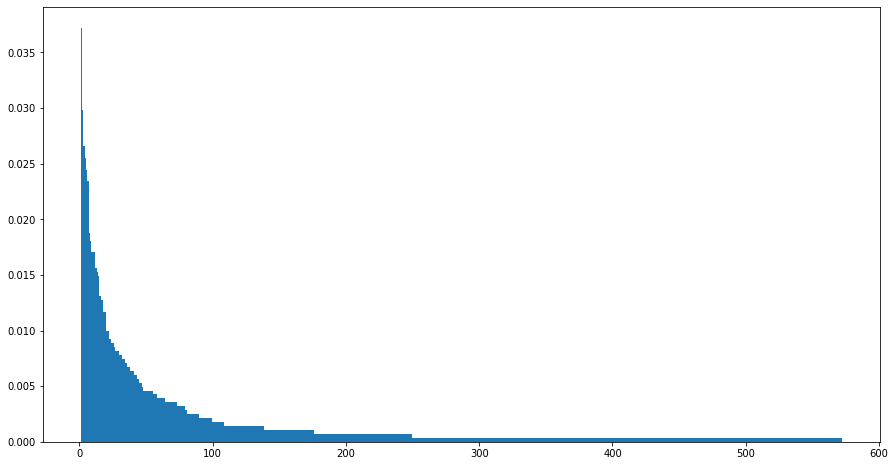

In [246]:
plt.hist(y, bins=len(users), density=True)
plt.show()

In [247]:
def get_best_args_plot_result(y, dist_name):
    #first
    plt.subplot(131)
    dist = getattr(scipy.stats, dist_name)
    plt.hist(y, density=True, alpha=0.5, bins=len(users))
    args = dist.fit(y, floc=0)
    x = np.linspace(y.min(), y.max(), 100)
    plt.plot(x, dist(*args).pdf(x))
    plt.title("{} fit on data".format(dist_name))
    
    #second
    plt.subplot(132)
    import statsmodels.distributions
    ecdf = statsmodels.distributions.ECDF(y)
    plt.plot(x, ecdf(x), label="Empirical CDF")
    plt.plot(x, dist(*args).cdf(x),label="{} fit".format(dist_name))
    plt.title("Cumulative failure intensity")
    plt.legend()
    #third
    plt.subplot(133)
    from scipy.stats import probplot
    probplot(y, dist=dist(*args),plot=plt)
    plt.title("{} QQ-plot".format(dist_name))
    
    #plt.show()
    return args

(3.8926170506914612, 0.3703452629344447, 0, 7.358981297843565)

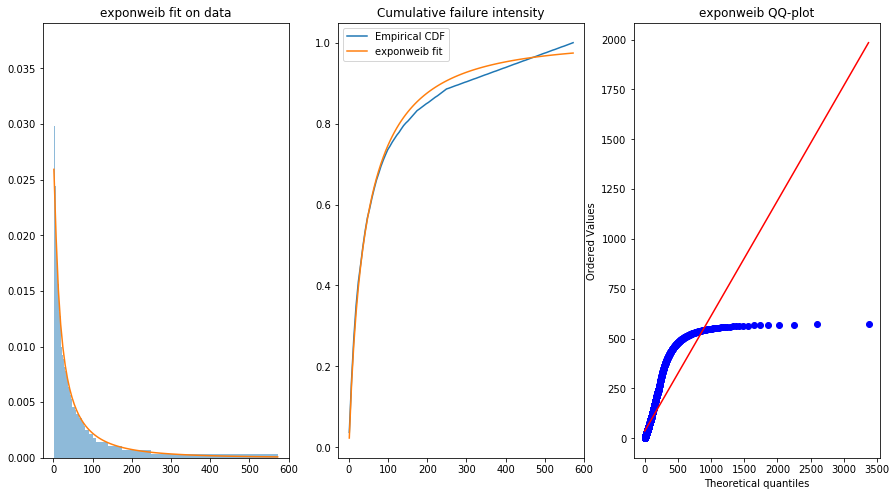

In [249]:
get_best_args_plot_result(y, 'exponweib')

https://pythonhealthcare.org/2018/05/03/81-distribution-fitting-to-data/

In [162]:
# Set list of distributions to test
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

# Turn off code warnings (this is not recommended for routine use)
import warnings
warnings.filterwarnings("ignore")

# Set up list of candidate distributions to use
# See https://docs.scipy.org/doc/scipy/reference/stats.html for more

dist_names = ['beta',
              'expon',
              'gamma',
              'halfcauchy',
              'halfnorm',
              'pearson3',
              'invgamma',
              'pareto',
              'weibull_min', 
              'weibull_max']

# Set up empty lists to stroe results
chi_square = []
p_values = []

# Set up 50 bins for chi-square test
# Observed data will be approximately evenly distrubuted aross all bins
percentile_bins = np.linspace(0,100,51)
percentile_cutoffs = np.percentile(y_std, percentile_bins)
observed_frequency, bins = (np.histogram(y_std, bins=percentile_cutoffs))
cum_observed_frequency = np.cumsum(observed_frequency)

# Loop through candidate distributions

for distribution in dist_names:
    # Set up distribution and get fitted distribution parameters
    dist = getattr(scipy.stats, distribution)
    param = dist.fit(y_std,floc=0)
    
    # Obtain the KS test P statistic, round it to 5 decimal places
    p = scipy.stats.kstest(y_std, distribution, args=param)[1]
    p = np.around(p, 5)
    p_values.append(p)    
    
    # Get expected counts in percentile bins
    # This is based on a 'cumulative distrubution function' (cdf)
    cdf_fitted = dist.cdf(percentile_cutoffs, *param[:-2], loc=param[-2], 
                          scale=param[-1])
    expected_frequency = []
    for bin in range(len(percentile_bins)-1):
        expected_cdf_area = cdf_fitted[bin+1] - cdf_fitted[bin]
        expected_frequency.append(expected_cdf_area)
    
    # calculate chi-squared
    expected_frequency = np.array(expected_frequency) * size
    cum_expected_frequency = np.cumsum(expected_frequency)
    ss_values = ((cum_expected_frequency - cum_observed_frequency) ** 2) / cum_observed_frequency
    ss_values = ss_values[~np.isnan(ss_values)]
    ss = sum (ss_values)
    chi_square.append(ss)
        
# Collate results and sort by goodness of fit (best at top)

results = pd.DataFrame()
results['Distribution'] = dist_names
results['chi_square'] = chi_square
results['p_value'] = p_values
results.sort_values(['chi_square'], inplace=True)
    
# Report results

print ('\nDistributions sorted by goodness of fit:')
print ('----------------------------------------')
print (results)


Distributions sorted by goodness of fit:
----------------------------------------
  Distribution    chi_square  p_value
7       pareto  34306.070565      0.0
6     invgamma  36043.514068      0.0
3   halfcauchy  39526.227893      0.0
8  weibull_min  40212.914608      0.0
1        expon  40410.260999      0.0
0         beta  40437.303641      0.0
2        gamma  40437.372205      0.0
4     halfnorm  43324.410079      0.0
5     pearson3  52601.284057      0.0
9  weibull_max  62913.000000      0.0


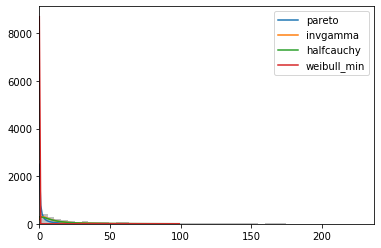


Distribution parameters:
------------------------

Distribution: pareto
Parameters: (0.4267737938917968, -0.9795870449036501, 1.9795870062456222)

Distribution: invgamma
Parameters: (1.3100596742217137, -6.354317116676448, 30.840606854596935)

Distribution: halfcauchy
Parameters: (0.9999999993160513, 25.7726955927975)

Distribution: weibull_min
Parameters: (0.7619397817895961, 0.9999999999999998, 57.58021526324379)


In [164]:
# Divide the observed data into 100 bins for plotting (this can be changed)
number_of_bins = 50
bin_cutoffs = np.linspace(np.percentile(y,0), np.percentile(y,99),number_of_bins)

# Create the plot
h = plt.hist(y, bins = bin_cutoffs, color='0.75')

# Get the top three distributions from the previous phase
number_distributions_to_plot = 4
dist_names = results['Distribution'].iloc[0:number_distributions_to_plot]

# Create an empty list to stroe fitted distribution parameters
parameters = []

# Loop through the distributions ot get line fit and paraemters

for dist_name in dist_names:
    # Set up distribution and store distribution paraemters
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    parameters.append(param)
    
    # Get line for each distribution (and scale to match observed data)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1])
    scale_pdf = np.trapz (h[0], h[1][:-1]) / np.trapz (pdf_fitted, x)
    pdf_fitted *= scale_pdf
    
    # Add the line to the plot
    plt.plot(pdf_fitted, label=dist_name)
    
    # Set the plot x axis to contain 99% of the data
    # This can be removed, but sometimes outlier data makes the plot less clear
    plt.xlim(0,np.percentile(y,99))

# Add legend and display plot

plt.legend()
plt.show()

# Store distribution paraemters in a dataframe (this could also be saved)
dist_parameters = pd.DataFrame()
dist_parameters['Distribution'] = (
        results['Distribution'].iloc[0:number_distributions_to_plot])
dist_parameters['Distribution parameters'] = parameters

# Print parameter results
print ('\nDistribution parameters:')
print ('------------------------')

for index, row in dist_parameters.iterrows():
    print ('\nDistribution:', row[0])
    print ('Parameters:', row[1] )